# OpenCL challenge - Edge detection with image correlation

## Introduction

The development of Convolutional neural networks has brought about a significant advance in machine learning capabilities in computer vision. Training and inference in Convolutional Neural networks rely on the application of many filters to an image via 2D discrete convolution. If $I$ is a 2D image and $K$ is a filter, then a 2D discrete convolution is 

$$V(i,j)=(I*K)(i,j)=\sum_{u}\sum_v I(i-u,j-v)K(u,v)$$

In practice, convolutional neural networks are not affected if the filter is flipped, so a conceptually-simpler cross-correlation is used instead. 

$$C(i,j)=(I\star K)(i,j)=\sum_{u}\sum_v I(i+u,j+v)K(u,v)$$


Source: The book **Deep Learning** by Goodfellow, Bengio, and Courville, available at this link [here](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=sr_1_3?ie=UTF8&qid=1533006310&sr=8-3&keywords=deep+learning).

The algorithm for implementing a cross-correlation can be visualised as follows. The image is padded with zeros and the filter is applied to every pixel in the filtered image, using the value in the pixel and its neighbours as the input. Points in the image are multiplied by corresponding points in the filter and the result is summed to produce a value at that pixel. By applying the filter across the image one can make a filtered image ready for further processing in the convolutional neural network.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="../images/correlation.svg" width="65%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: The cross-correlation algorithm with an edge detection filter. The fillter (in orange) is cross-correlated with the image. The blue region of the image represents the region over which the correlation is valid. The white region is the padding. </figcaption>
</figure>



### Flops count for a 3x3 filter

* 18 fetches (2x9)
* 1 store
* 18 FLOPs
* 4 Bytes per element

FLOPs / Byte ratio == 0.24, memory bandwidth limited!



## Construct the input data

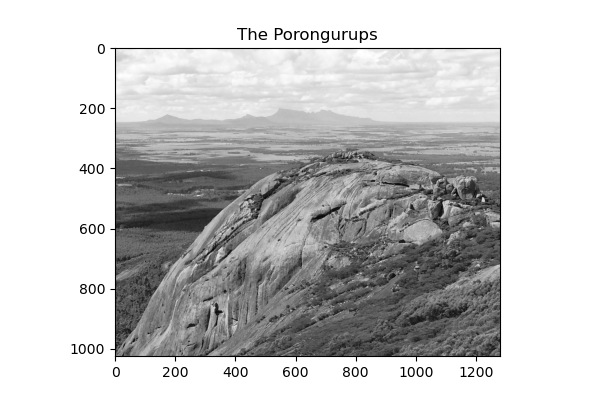

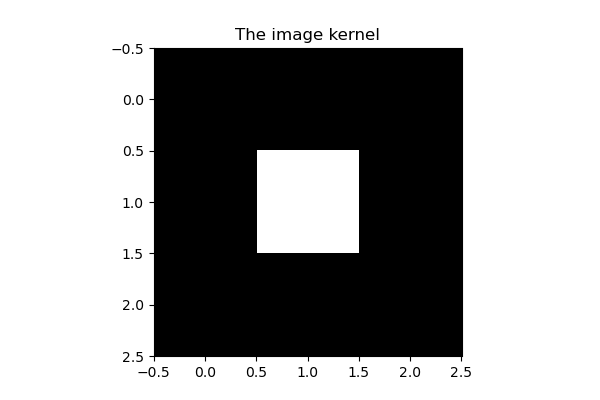

In [13]:
import numpy as np
import skimage
from ipywidgets import widgets
from matplotlib import pyplot as plt
from skimage import color, io
import os
import sys
sys.path.insert(0, os.path.abspath("../include"))
import py_helper

def fetch_image(large_image, offset0, offset1, N0, N1):
    return large_image[offset0: offset0+N0, offset1: offset1+N1]

%matplotlib widget

# Get array sizes directly from mat_size.hpp
defines=py_helper.load_defines("mat_size.hpp")

# define a standard data type
float_type = np.float32

# Read in the image
im_col = io.imread(os.path.join("..","images","Porongorups.JPG"))
large_image = color.rgb2gray(im_col).astype(float_type)
start0=747
start1=1175
sample_image = fetch_image(large_image, start0, start1, defines["N0"], defines["N1"])

# Plot the image
[fig, ax] = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(sample_image, cmap=plt.get_cmap("Greys_r"))
ax.set_title("The Porongurups")
plt.show()

# Get the filter
filtr = np.zeros((3,3), dtype=float_type) - 1.0
filtr[1,1] = 8.0
# Since we are doing a cross-correlation these paddings apply
pad0_l = defines["L0"]
pad0_r = defines["R0"]
pad1_l = defines["L1"]
pad1_r = defines["R1"]

# Plot the image kernel
[fig, ax] = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(filtr, cmap=plt.get_cmap("Greys_r"))
ax.set_title("The image kernel")
plt.show()

In [18]:
# Write images to file

# Number of images to write
nimages = defines["NIMAGES"]

# Make a stack of images to write
images_in = np.zeros((nimages, *sample_image.shape), dtype=sample_image.dtype)
for n in range(0, nimages):
    images_in[n,:,:] = fetch_image(large_image, start0, start1+n, defines["N0"], defines["N1"])
    
# Write out the images to file
images_in.tofile("images_in.dat")

# Write out the filter to file
filtr.tofile("image_kernel.dat")

# Plot the input images
py_helper.plot_slices(images_in)

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

## Python cross-correlation algorithms

In [15]:
import time

import numpy as np
from scipy.signal import correlate

def xcor2d_slicing(image_in, image_out, filtr, pad0_l, pad0_r, pad1_l, pad1_r):
    """2D cross correlation that uses the full Numpy array."""
    reduced_shape = (image_in.shape[0] - pad0_l -pad0_r, image_in.shape[1] - pad1_l - pad1_r)
    selection = np.s_[pad0_l : pad0_l+reduced_shape[0], pad1_l : pad1_l + reduced_shape[1]]
    result = np.zeros(reduced_shape, dtype=image_in.dtype)

    # Loop over the filter which is of small size
    for x in range(-pad0_l, pad0_r+1):
        for y in range(-pad1_l, pad1_r+1):
            temp = image_in[
                x + pad0_l : x + pad0_l + reduced_shape[0], y + pad1_l : y + pad1_l + reduced_shape[1]
            ]
            result = result + filtr[x+pad0_l, y+pad1_l] * temp

    image_out[selection] = result
            
def xcor2d_scipy(image_in, image_out, filtr):
    """A canned Scipy function."""
    image_out[:] = correlate(image_in, filtr, mode="same", method="direct")

# Test case
py_images_out = np.zeros_like(images_in)
    
# Time how quick Python takes to run
t1 = time.perf_counter()

image_out = np.zeros_like(sample_image)
for n in range(0, nimages):
    image_in = images_in[n, :, :]
    xcor2d_slicing(image_in, image_out, filtr, pad0_l, pad0_r, pad1_l, pad1_r)
    #xcor2d_scipy(image_in, image_out, filtr)
    py_images_out[n,...] = image_out[:]
    
t2 = time.perf_counter()
print(f"Python image processing rate is {nimages/(t2-t1):.2f} images/s")

# Using Scipy took me about 5.30 images/s

Python image processing rate is 142.60 images/s


### Check correlation solution

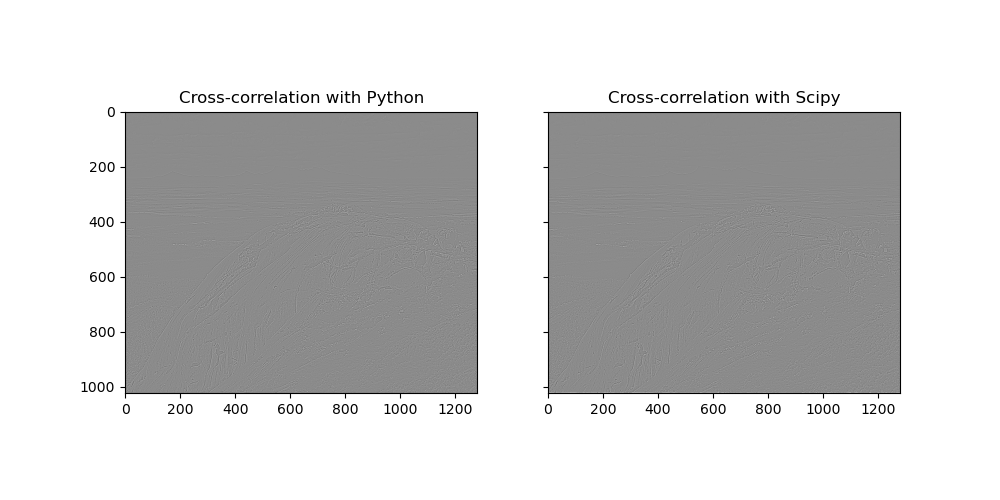

In [16]:
from scipy.signal import correlate

# Plot the image
index = 0

# Image from input
image_in = images_in[index,:,:]

# Image from output
image_out = py_images_out[index,:,:]

# Make up a proof image to compare against
proof_image = correlate(image_in, filtr, mode="same", method="direct")

# Get indices which are not 0
indices = np.where(image_out != 0)
vmin = np.min(image_out[indices])
vmax = np.max(image_out[indices])

[fig, ax] = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(image_out, vmin=vmin, vmax=vmax, cmap=plt.get_cmap("Greys_r"))
ax[0].set_title("Cross-correlation with Python")

ax[1].imshow(proof_image, vmin=vmin, vmax=vmax, cmap=plt.get_cmap("Greys_r"))
ax[1].set_title("Cross-correlation with Scipy")

plt.show()

In [17]:
py_helper.plot_slices(py_images_out)

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

## OpenCL solution

When processing multiple images with OpenCL the correlation process can be farmed out to multiple compute devices, as shown below.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="../images/farming_out.svg" width="65%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: Farming out the cross-correlations among available devices. </figcaption>
</figure>

* [source_code](xcorr.cpp)
* [helper_header](cl_helper.hpp)
* [kernel_source](kernels.cl)

### Inspect devices

In [48]:
!clinfo -l

Platform #0: Intel(R) FPGA Emulation Platform for OpenCL(TM)
 `-- Device #0: Intel(R) FPGA Emulation Device
Platform #1: Intel(R) OpenCL
 `-- Device #0: AMD Ryzen 7 6800H with Radeon Graphics         
Platform #2: AMD Accelerated Parallel Processing
 `-- Device #0: gfx1035
Platform #3: NVIDIA CUDA
 `-- Device #0: NVIDIA GeForce RTX 3060 Laptop GPU


### Compile and run the program

In its current configuration, each iteration processes 1024 images, where each image consists of 1024x1280 floats.

In [51]:
!make clean; make

rm -r *.exe
g++ -std=c++11 -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu xcorr_answers.cpp\
	-o xcorr_answers.exe -lOpenCL -lclblast
In file included from xcorr_answers.cpp:4:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:330:49: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  330 |         command_queues[n] = clCreateCommandQueue(
      |                             ~~~~~~~~~~~~~~~~~~~~^
  331 |             contexts[n % num_devices],
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~~           
  332 |             devices[n % num_devices],
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~            
  333 |             queue_proper

### CPU only

In [52]:
!./xcorr_answers.exe -cpu

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Processing iteration 1 of 1
Device 0 processed 100 of 100 images (100.00%)
Overall processing rate 1419.12 images/s


### GPUs only

In [53]:
!./xcorr_answers.exe -gpu

	               name: gfx1035 
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Processing iteration 1 of 1
Device 0 processed 49 of 100 images (49.00%)
Device 1 processed 51 of 100 images (51.00%)
Overall processing rate 969.46 images/s


### CPU's and GPU's

In [54]:
!./xcorr_answers.exe

	               name: Intel(R) FPGA Emulation Device 
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (67108864,67108864,67108864)
	     max work-items: 67108864
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
	               name: gfx1035 
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Processing iteration 1 of 1
Device 0 processed 17 of 100 images (17.00%)
Device 1 processed 35 of 100 images (35.00%)
Device 2 processed 21 of 100 images (21.00%)
Device 3 processed 27 of 100 images (27.00%)
Overall processing rate 1027.19 images/s


### Read and check the results

In [55]:
# Read the image
images_out = np.fromfile("images_out.dat", dtype=image.dtype).reshape((nimages,*image.shape))

In [56]:
from scipy.signal import correlate

# Plot the image
index = 1023

# Image from input
image_in = images_in[index,:,:]

# Image from output
image_out = images_out[index,:,:]

# Make up a proof image to compare against
proof_image = correlate(image_in, filtr, mode="same", method="direct")

# Get indices which are not 0
indices = np.where(image_out != 0)
vmin = np.min(image_out[indices])
vmax = np.max(image_out[indices])

[fig, ax] = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(image_out, vmin=vmin, vmax=vmax, cmap=plt.get_cmap("Greys_r"))
ax[0].set_title("Cross-correlation with OpenCL")

ax[1].imshow(proof_image, vmin=vmin, vmax=vmax, cmap=plt.get_cmap("Greys_r"))
ax[1].set_title("Cross-correlation with Scipy")

plt.show()

IndexError: index 1023 is out of bounds for axis 0 with size 100